In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from models.interactive_parameter import InteractiveUtils

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [6]:
def clip(
    values: np.ndarray, min_value: float = None, max_value: float = None
) -> np.ndarray:
    return np.clip(values, min_value, max_value)


def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 10e3:
            transformed_stakes.append(1e-20)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes


def equation_single(X, num, *args, **kwargs):
    B = kwargs[f"B{num}"]
    K = kwargs[f"K{num}"]
    nu = kwargs[f"nu{num}"]
    E = kwargs[f"E{num}"]

    try:
        inner = np.power((K / X), nu) - 1
        output: np.ndarray = clip(E + B * np.log(inner), 0, 8.5)
    except ZeroDivisionError:
        output: np.ndarray = np.zeros_like(X)

    return output


def sigmoid_plot_composition(ax, x_range, y_range, constant, label, maximum):
    percents = [0.10, 0.20, 0.50, 0.90, 1]

    for percent in percents:
        y_values = [y * percent + constant * (1 - percent) for y in y_range]
        ax.plot(x_range, y_values, label=f"{percent:.0%}")

    ax.set_xlabel(label)
    ax.set_ylabel("APR (%)")

    # set labels on two lines
    ticks_labels = [f"{tick:.0%}\n{tick*maximum:.0f}" for tick in ax.get_xticks()]
    ax.set_xticklabels(ticks_labels)

    ax.grid("both")
    ax.legend()

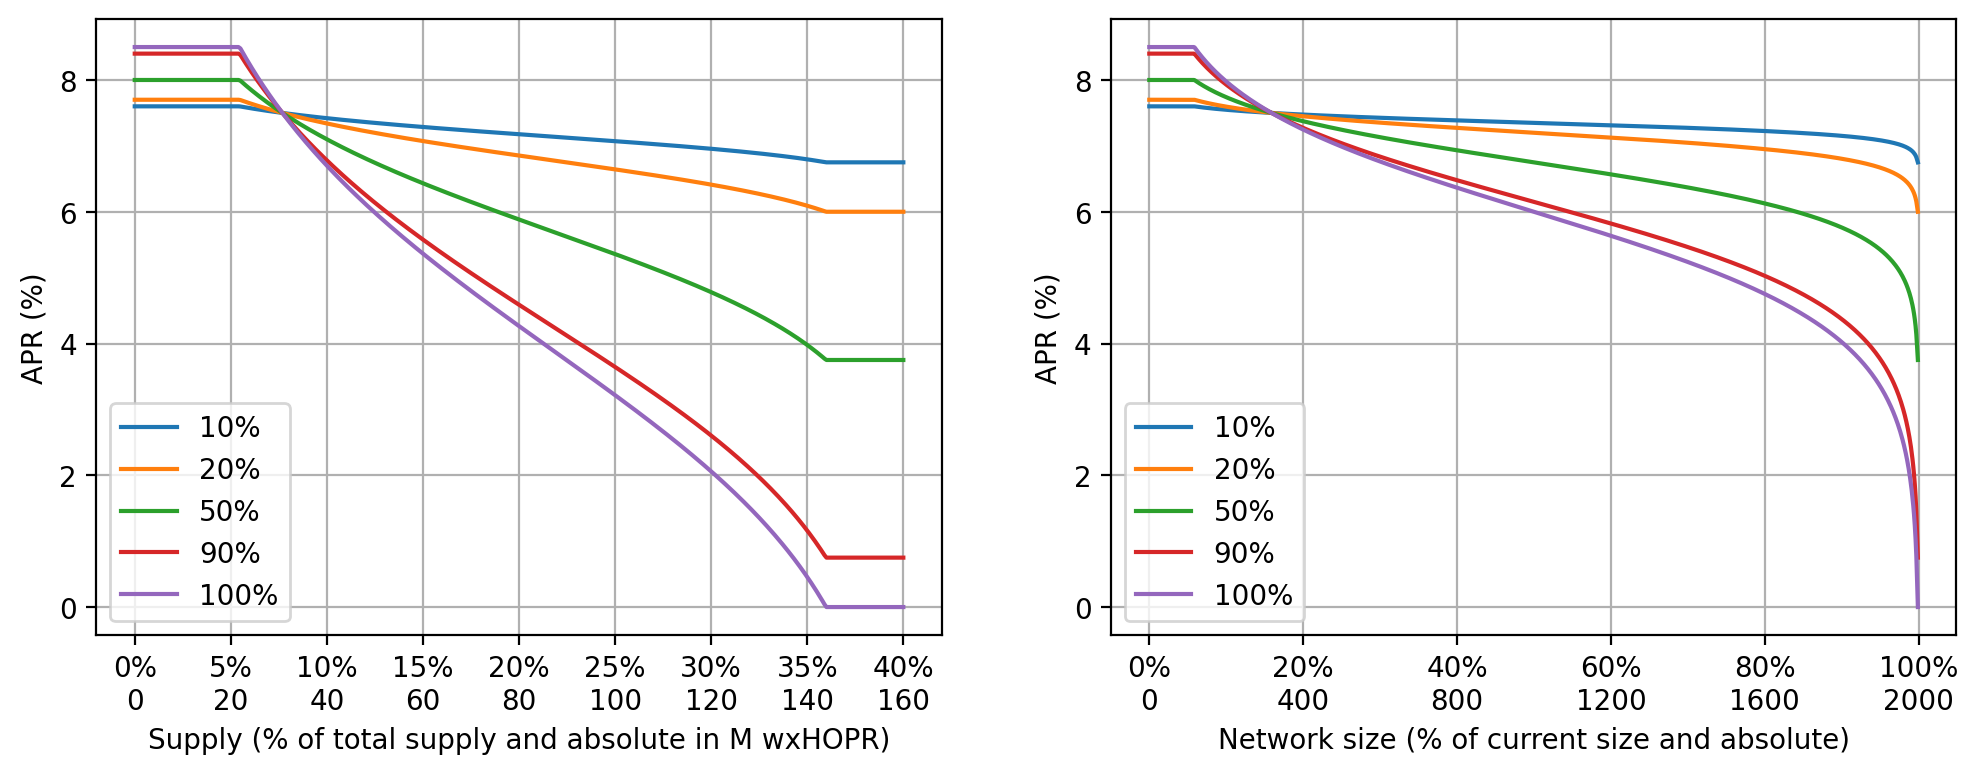

In [7]:
def plot_composition(*args, **kwargs):
    fig = plt.figure(figsize=(12, 4))
    axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]

    range_x = np.arange(0.000, 0.5, 0.001)
    range_y = np.arange(0.000, 1, 0.001)

    # 2D plot
    sigmoid_plot_composition(
        axes[0],
        range_x,
        equation_single(range_x, 1, **kwargs),
        7.5,
        "Supply (% of total supply and absolute in M wxHOPR)",
        400,
    )

    sigmoid_plot_composition(
        axes[1],
        range_y,
        equation_single(range_y, 2, **kwargs),
        7.5,
        "Network size (% of current size and absolute)",
        2000,
    )

    plt.subplots_adjust(wspace=0.2)


params = InteractiveUtils.loadSimulationConfigFile("assets/sigmoid.config.pow.1.2.yaml")
plot_composition(**{param.name: param.value for param in params})

In [4]:
x_range = np.arange(0, 250e3, 100)
y_range = np.array(stake_transformation(x_range, 1, 1.4, 75e3))

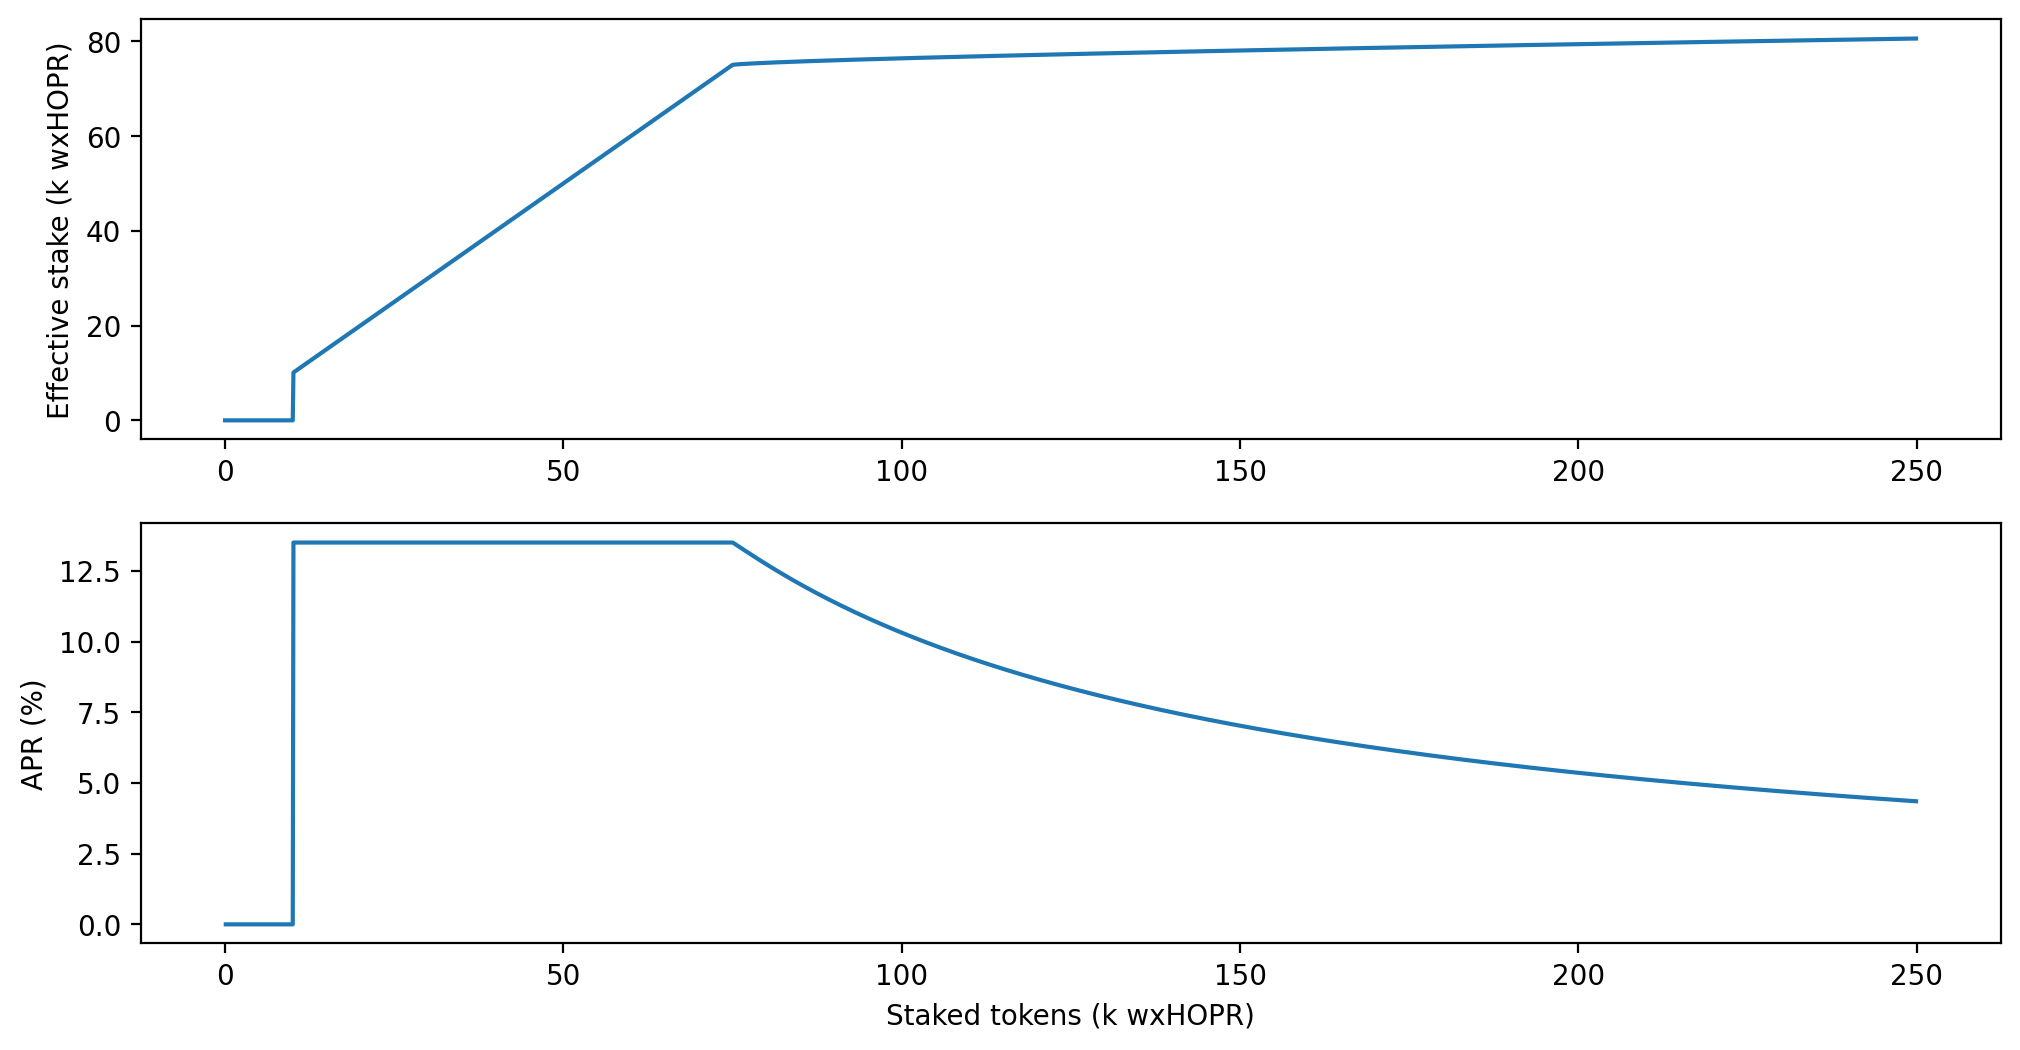

In [5]:
x_range_k = x_range / 1e3
y_range_k = y_range / x_range * 13.5

fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2, 1, 1), fig.add_subplot(2, 1, 2)]
axes[1].sharex(axes[0])

axes[1].plot(x_range_k, y_range_k)
axes[1].set_xlabel("Staked tokens (k wxHOPR)")
axes[1].set_ylabel("APR (%)")

axes[0].plot(x_range_k, y_range / 1e3)
axes[0].set_ylabel("Effective stake (k wxHOPR)")

plt.show()